In [ ]:
import pandas as pd
import vcfpy
from SigProfilerAssignment import Analyzer as Analyze
import musical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import shutil
import ast
from tqdm import tqdm 
import re
import sys
from scipy import stats
from contextlib import redirect_stdout
from tabulate import tabulate
import csv
from scipy import odr

pd.set_option("display.max_columns", None)
from hrdtimer import utils as HRDTimerUtils
%matplotlib inline

# PCAWG

## 0. Preprocess TimeR Output / Split vcfs early - late

In [ ]:
input_folder_path = "PCAWG/hrdtimer_results_v3"
output_folder_path = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2"
organ_csv_path = "breast_ovarian_summary_with_age.csv"

# Ensure the output folder exists
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

HRDTimerUtils.process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=False)
HRDTimerUtils.process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=True)

Processing VCFs: 100%|██████████| 317/317 [01:36<00:00,  3.28it/s]


## 1. Breast Cancer Samples

### 1.2 Signature fitting / probability of mutation-attribution to Signatures

In [ ]:
all_muts = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/all_mut/"
timing_muts = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/timing/"
HRDTimerUtils.run_Signature_Analysis(all_muts, genome_build="GRCh37")
HRDTimerUtils.run_Signature_Analysis(timing_muts, genome_build="GRCh37")

### 1.3 Prepare / load required data to run timing

In [ ]:
vcf_folder_path = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/timing"
breast_samples = HRDTimerUtils.prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 202/202 [00:21<00:00,  9.48it/s]


Processing Late samples:


Processing Files: 100%|██████████| 174/174 [00:22<00:00,  7.79it/s]


Processing NA samples:


Processing Files: 100%|██████████| 205/205 [00:18<00:00, 11.04it/s]


In [ ]:
# Read the CSV file into a DataFrame
breast_metadata_path = 'breast_ovarian_summary_with_age_hrd_grade.csv'
breast_metadata = pd.read_csv(breast_metadata_path)
breast_samples_list = list(breast_samples.keys()) # From vcf files
breast_samples_metadata_df = breast_metadata[breast_metadata['aliquot_id'].isin(breast_samples_list)]

breast_samples_metadata_df = breast_samples_metadata_df[breast_samples_metadata_df['WGD'] == True]
breast_samples_WGD_IDs = breast_samples_metadata_df['aliquot_id'].tolist()
#HRD
HRD_WGD_breast_samples_IDs = breast_metadata.loc[
    (breast_metadata['isHRD']) & 
    (breast_metadata['organ.x'] == 'Breast') & 
    (breast_metadata['WGD'] == True), 
    'aliquot_id'
]
HRD_samples = HRD_WGD_breast_samples_IDs.tolist()

In [185]:
# For timing analysis keep samples with WGD only
breast_samples_WGD = {key: breast_samples[key] for key in breast_samples_WGD_IDs if key in breast_samples}
breast_samples_WGD_HRD = {key: breast_samples[key] for key in HRD_samples if key in breast_samples}

### 1.4 Timing Analysis

In [ ]:
WGDTime_means = {}
WGDTime_CpGs = {}
WGDTime_error = {}
WGDTime_CpGs_error = {}
NmutCpG = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_CpG, _, WDGTime, WGDTime_CI = HRDTimerUtils.calculate_WGDtime_prob_bootstrapping(sample_df)
    _, _, WGDTime_CpG, WGDTime_CpG_CI = HRDTimerUtils.calculate_WGDtime_prob_bootstrapping_CTpG(sample_df)
    # Store the results for the current sample
    WGDTime_means[sample_id] = WDGTime
    WGDTime_error[sample_id] = WGDTime_CI
    NmutCpG[sample_id] = N_mut_CpG.tolist()

    WGDTime_CpGs[sample_id] = WGDTime_CpG
    WGDTime_CpGs_error[sample_id] = WGDTime_CpG_CI

Processing Samples: 100%|██████████| 34/34 [01:53<00:00,  3.34s/it]


## ------------- Example plot time WGD with SBS1 vs CpG

Best-fit line (through origin): y = 0.974 * x
Chi-squared: 9.330
Reduced Chi-squared: 0.283


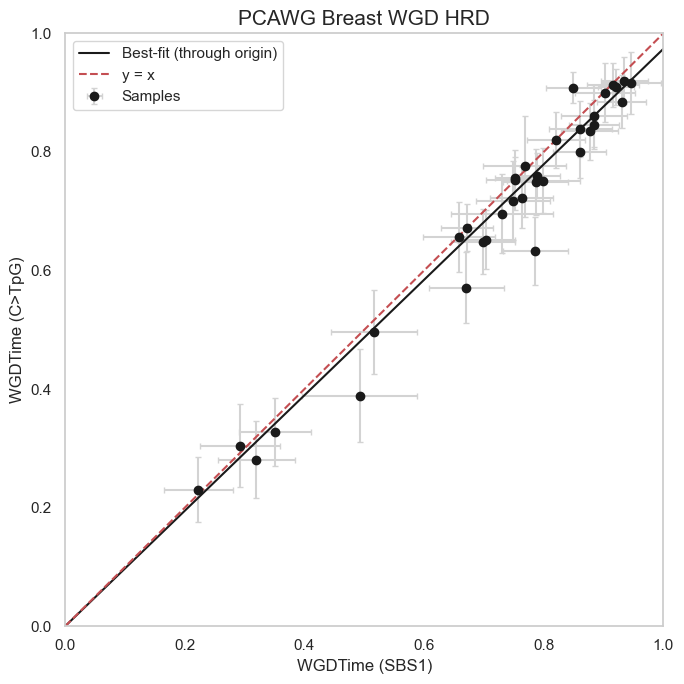

In [ ]:
# Combine into a DataFrame
df = pd.DataFrame({
    "WGDTime_mean": pd.Series(WGDTime_means),
    "WGDTime_mean_error": pd.Series(WGDTime_error),
    "WGDTime_CpG": pd.Series(WGDTime_CpGs),
    "WGDTime_CpG_error": pd.Series(WGDTime_CpGs_error),
})

# Drop NaNs
df = df.dropna()

# Define model (force intercept to 0)
def linear_through_origin(B, x):
    return B[0] * x

model = odr.Model(linear_through_origin)

# Create data object with errors
data = odr.RealData(
    df["WGDTime_mean"],
    df["WGDTime_CpG"],
    sx=df["WGDTime_mean_error"],
    sy=df["WGDTime_CpG_error"]
)

# Run ODR
odr_instance = odr.ODR(data, model, beta0=[1.])
output = odr_instance.run()

# Extract values
slope = output.beta[0]
chi2 = output.sum_square  # Chi-squared
dof = len(df) - 1  # degrees of freedom = n - number of fitted params
reduced_chi2 = chi2 / dof

# Print results
print(f"Best-fit line (through origin): y = {slope:.3f} * x")
print(f"Chi-squared: {chi2:.3f}")
print(f"Reduced Chi-squared: {reduced_chi2:.3f}")

# Plot
plt.figure(figsize=(7, 7))
plt.errorbar(
    df["WGDTime_mean"],
    df["WGDTime_CpG"],
    xerr=df["WGDTime_mean_error"],
    yerr=df["WGDTime_CpG_error"],
    fmt='o',
    color='k',
    ecolor='lightgrey',
    capsize=2,
    label='Samples'
)

# Best-fit line
x_vals = np.linspace(0, 1, 100)
y_vals = slope * x_vals
plt.plot(x_vals, y_vals, 'k-', label='Best-fit (through origin)')

# Reference line
plt.plot([0,1], [0,1], 'r--', label='y = x')

# Annotate chi-squared on plot
#plt.text(0.05, 0.9, f"$\\chi^2$ = {chi2:.3f}\nReduced $\\chi^2$ = {reduced_chi2:.3f}", fontsize=10)

# Aesthetics
plt.xlabel("WGDTime (SBS1)")
plt.ylabel("WGDTime (C>TpG)")
plt.title("PCAWG Breast WGD HRD", fontsize=15)
plt.grid(False)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.legend()
plt.show()

From the above plot the outlier that the time is pushed earlier in the SBS1 prob formula is interesting. This sample is an APOBEC sample. Signature exposures show that APOBEC is active early in the sample. From the calculation of probabilities, several contexts such as the TCG>T are assigned almost by 0.98 percent to originate from APOBEC in such a sample and not from a timing process. Hence if we naively took all C>Ts at CG contexts, we would overestimate the proportion of early timing mutations and that would push the timing estimate higher. This is effect is corrected with this new approach

In [ ]:
HRDTime_means = {}
HRDTime_error = {}
pi2SBS1_means = {}
pi2SBS1_err = {}
pi2SBS3_means = {}
pi2SBS3_err = {} 
pi1SBS1_means = {}
pi1SBS1_err = {}
pi1SBS3_means = {}
pi1SBS3_err = {}
c = {}
c_avg = {}
NtSBS1 ={}
NtSBS3 ={}
Nmutall = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_all, _, HRD_time, HRD_time_CI, c_val_mean, cavg, Nt_SBS1, Nt_SBS3, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err = HRDTimerUtils.calculate_HRDtime_prob_bootstrapping(sample_df)
    # Store the results for the current sample
    HRDTime_means[sample_id] = HRD_time
    HRDTime_error[sample_id] = HRD_time_CI
    pi2SBS1_means[sample_id] = pi_2_SBS1_mean
    pi2SBS1_err[sample_id] = pi_2_SBS1_err
    pi2SBS3_means[sample_id] = pi_2_SBS3_mean
    pi2SBS3_err[sample_id] = pi_2_SBS3_err
    pi1SBS1_means[sample_id] = pi_1_SBS1_mean
    pi1SBS1_err[sample_id] = pi_1_SBS1_err
    pi1SBS3_means[sample_id] = pi_1_SBS3_mean
    pi1SBS3_err[sample_id] = pi_1_SBS3_err
    c[sample_id] = c_val_mean 
    c_avg[sample_id] = cavg
    NtSBS1[sample_id] = Nt_SBS1
    NtSBS3[sample_id] = Nt_SBS3
    Nmutall[sample_id] = N_mut_all.tolist()

Processing Samples: 100%|██████████| 34/34 [36:36<00:00, 64.60s/it]


In [ ]:
results = []

# Loop through each filtered ID, calculate HRD time, and store the results
for aliquot_id in HRD_samples:
    if aliquot_id in breast_samples:
        n_mut_CpG = NmutCpG.get(aliquot_id, "Not available")
        n_mut_all = Nmutall.get(aliquot_id, "Not available")
        
        hrd_time = HRDTime_means.get(aliquot_id, "Not available")
        hrd_time_error = HRDTime_error.get(aliquot_id, "Not available")

        wgd_time = WGDTime_means.get(aliquot_id, "Not available")
        wgd_time_error = WGDTime_error.get(aliquot_id, "Not available")

        wgd_time_cpg = WGDTime_CpGs.get(aliquot_id, "Not available")
        wgd_time_cpg_err = WGDTime_CpGs_error.get(aliquot_id, "Not available")

        pi2SBS1_mean = pi2SBS1_means.get(aliquot_id, "Not available")
        pi2SBS1_error = pi2SBS1_err.get(aliquot_id, "Not available")

        pi2SBS3_mean = pi2SBS3_means.get(aliquot_id, "Not available")
        pi2SBS3_error = pi2SBS3_err.get(aliquot_id, "Not available")

        pi1SBS1_mean = pi1SBS1_means.get(aliquot_id, "Not available")
        pi1SBS1_error = pi1SBS1_err.get(aliquot_id, "Not available")

        pi1SBS3_mean = pi1SBS3_means.get(aliquot_id, "Not available")
        pi1SBS3_error = pi1SBS3_err.get(aliquot_id, "Not available")

        C = c.get(aliquot_id, "Not available")
        C_avg = c_avg.get(aliquot_id, "Not available")

        Nt_SBS1 = NtSBS1.get(aliquot_id, "Not available")
        Nt_SBS3 = NtSBS3.get(aliquot_id, "Not available")
        
        results.append([aliquot_id, hrd_time, hrd_time_error, wgd_time, wgd_time_error, wgd_time_cpg, wgd_time_cpg_err, pi2SBS1_mean, pi2SBS1_error, pi2SBS3_mean, pi2SBS3_error, pi1SBS1_mean, pi1SBS1_error, pi1SBS3_mean, pi1SBS3_error, C, C_avg, Nt_SBS1, Nt_SBS3, n_mut_CpG, n_mut_all])

# Print the results as a table
print(tabulate(results, headers=["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"], tablefmt="grid"))

with open('PCAWG_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"])
    # Write the data
    writer.writerows(results)

## 2. Ovary Cancer Samples

### 2.1 Signature fitting / probability of mutation-attribution to Signatures

In [ ]:
all_muts = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Ovary/all_mut/"
timing_muts = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Ovary/timing/"
HRDTimerUtils.run_Signature_Analysis(all_muts, genome_build="GRCh37")
HRDTimerUtils.run_Signature_Analysis(timing_muts, genome_build="GRCh37")

### 2.2 Prepare / load required data to run timing

In [ ]:
vcf_folder_path = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Ovary/timing"
ovary_samples = HRDTimerUtils.prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 109/109 [00:11<00:00,  9.66it/s]


Processing Late samples:


Processing Files: 100%|██████████| 107/107 [00:17<00:00,  6.07it/s]


Processing NA samples:


Processing Files: 100%|██████████| 109/109 [00:14<00:00,  7.78it/s]


In [212]:
# Read the CSV file into a DataFrame
ovary_metadata_path = 'breast_ovarian_summary_with_age_hrd_grade.csv'
ovary_metadata = pd.read_csv(ovary_metadata_path)
ovary_samples_list = list(ovary_samples.keys()) # From vcf files
ovary_samples_metadata_df = ovary_metadata[ovary_metadata['aliquot_id'].isin(ovary_samples_list)]
#WGD
#Keep only samples with WGD
ovary_samples_metadata_df = ovary_samples_metadata_df[ovary_samples_metadata_df['WGD'] == True]
ovary_samples_WGD_IDs = ovary_samples_metadata_df['aliquot_id'].tolist()
#HRD
HRD_WGD_ovary_samples_IDs = ovary_metadata.loc[
    (ovary_metadata['isHRD']) & 
    (ovary_metadata['organ.x'] == 'Ovary') & 
    (ovary_metadata['WGD'] == True), 
    'aliquot_id'
]
HRD_samples = HRD_WGD_ovary_samples_IDs.tolist()

In [213]:
# For timing analysis keep samples with WGD only
ovary_samples_WGD = {key: ovary_samples[key] for key in ovary_samples_WGD_IDs if key in ovary_samples}
ovary_samples_WGD_HRD = {key: ovary_samples[key] for key in HRD_samples if key in ovary_samples}

In [ ]:
WGDTime_means = {}
WGDTime_CpGs = {}
WGDTime_error = {}
WGDTime_CpGs_error = {}
NmutCpG = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(ovary_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_CpG, _, WDGTime, WGDTime_CI = HRDTimerUtils.calculate_WGDtime_prob_bootstrapping(sample_df)
    _, _, WGDTime_CpG, WGDTime_CpG_CI = HRDTimerUtils.calculate_WGDtime_prob_bootstrapping_CTpG(sample_df)
    # Store the results for the current sample
    WGDTime_means[sample_id] = WDGTime
    WGDTime_error[sample_id] = WGDTime_CI
    NmutCpG[sample_id] = N_mut_CpG.tolist()

    WGDTime_CpGs[sample_id] = WGDTime_CpG
    WGDTime_CpGs_error[sample_id] = WGDTime_CpG_CI

Processing Samples: 100%|██████████| 27/27 [01:47<00:00,  3.98s/it]


In [ ]:
HRDTime_means = {}
HRDTime_error = {}
pi2SBS1_means = {}
pi2SBS1_err = {}
pi2SBS3_means = {}
pi2SBS3_err = {} 
pi1SBS1_means = {}
pi1SBS1_err = {}
pi1SBS3_means = {}
pi1SBS3_err = {}
c = {}
c_avg = {}
NtSBS1 ={}
NtSBS3 ={}
Nmutall = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(ovary_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_all, _, HRD_time, HRD_time_CI, c_val_mean, cavg, Nt_SBS1, Nt_SBS3, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err = HRDTimerUtils.calculate_HRDtime_prob_bootstrapping(sample_df)
    # Store the results for the current sample
    HRDTime_means[sample_id] = HRD_time
    HRDTime_error[sample_id] = HRD_time_CI
    pi2SBS1_means[sample_id] = pi_2_SBS1_mean
    pi2SBS1_err[sample_id] = pi_2_SBS1_err
    pi2SBS3_means[sample_id] = pi_2_SBS3_mean
    pi2SBS3_err[sample_id] = pi_2_SBS3_err
    pi1SBS1_means[sample_id] = pi_1_SBS1_mean
    pi1SBS1_err[sample_id] = pi_1_SBS1_err
    pi1SBS3_means[sample_id] = pi_1_SBS3_mean
    pi1SBS3_err[sample_id] = pi_1_SBS3_err
    c[sample_id] = c_val_mean 
    c_avg[sample_id] = cavg
    NtSBS1[sample_id] = Nt_SBS1
    NtSBS3[sample_id] = Nt_SBS3
    Nmutall[sample_id] = N_mut_all.tolist()

Processing Samples: 100%|██████████| 27/27 [30:56<00:00, 68.76s/it] 


In [ ]:
results = []

# Loop through each filtered ID, calculate HRD time, and store the results
for aliquot_id in HRD_samples:
    if aliquot_id in ovary_samples:
        n_mut_CpG = NmutCpG.get(aliquot_id, "Not available")
        n_mut_all = Nmutall.get(aliquot_id, "Not available")
        
        hrd_time = HRDTime_means.get(aliquot_id, "Not available")
        hrd_time_error = HRDTime_error.get(aliquot_id, "Not available")

        wgd_time = WGDTime_means.get(aliquot_id, "Not available")
        wgd_time_error = WGDTime_error.get(aliquot_id, "Not available")

        wgd_time_cpg = WGDTime_CpGs.get(aliquot_id, "Not available")
        wgd_time_cpg_err = WGDTime_CpGs_error.get(aliquot_id, "Not available")

        pi2SBS1_mean = pi2SBS1_means.get(aliquot_id, "Not available")
        pi2SBS1_error = pi2SBS1_err.get(aliquot_id, "Not available")

        pi2SBS3_mean = pi2SBS3_means.get(aliquot_id, "Not available")
        pi2SBS3_error = pi2SBS3_err.get(aliquot_id, "Not available")

        pi1SBS1_mean = pi1SBS1_means.get(aliquot_id, "Not available")
        pi1SBS1_error = pi1SBS1_err.get(aliquot_id, "Not available")

        pi1SBS3_mean = pi1SBS3_means.get(aliquot_id, "Not available")
        pi1SBS3_error = pi1SBS3_err.get(aliquot_id, "Not available")

        C = c.get(aliquot_id, "Not available")
        C_avg = c_avg.get(aliquot_id, "Not available")

        Nt_SBS1 = NtSBS1.get(aliquot_id, "Not available")
        Nt_SBS3 = NtSBS3.get(aliquot_id, "Not available")
        
        results.append([aliquot_id, hrd_time, hrd_time_error, wgd_time, wgd_time_error, wgd_time_cpg, wgd_time_cpg_err, pi2SBS1_mean, pi2SBS1_error, pi2SBS3_mean, pi2SBS3_error, pi1SBS1_mean, pi1SBS1_error, pi1SBS3_mean, pi1SBS3_error, C, C_avg, Nt_SBS1, Nt_SBS3, n_mut_CpG, n_mut_all])

# Print the results as a table
print(tabulate(results, headers=["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"], tablefmt="grid"))

with open('PCAWG_Ovary_WGD_HRD_TimingResults_v9_timing_nboot200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"])
    # Write the data
    writer.writerows(results)

# SCANB

In [221]:
SCANB_metadata_path = 'hrdtimer_SCANB_selected.csv'
SCANB_metadata = pd.read_csv(SCANB_metadata_path)
SCANB_metadata['isHRD'] = True
SCANB_metadata['organ'] = 'Breast'
SCANB_metadata['WGD'] = True
SCANB_metadata['aliquot_id'] = SCANB_metadata['SangerID.Tumour']
#output_csv_path = 'SCANB_metadata.csv'  # Replace with your desired output CSV file path
#SCANB_metadata.to_csv(output_csv_path, index=False)

In [ ]:
input_folder_path = "SCANB/hrdtimer_results_unfiltered"
output_folder_path = "AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25"
organ_csv_path = "SCANB_metadata.csv"

# Ensure the output folder exists
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

HRDTimerUtils.process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=False)
HRDTimerUtils.process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=True)

Processing VCFs: 100%|██████████| 240/240 [00:17<00:00, 13.93it/s]


In [ ]:
all_muts = "AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/all_mut"
timing_muts = "AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/timing"
HRDTimerUtils.run_Signature_Analysis(all_muts, genome_build="GRCh37")
HRDTimerUtils.run_Signature_Analysis(timing_muts, genome_build="GRCh37")

In [ ]:
vcf_folder_path = "AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/timing"
breast_samples = HRDTimerUtils.prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]


Processing Late samples:


Processing Files: 100%|██████████| 49/49 [00:07<00:00,  6.70it/s]


Processing NA samples:


Processing Files: 100%|██████████| 49/49 [00:06<00:00,  7.91it/s]


In [225]:
WGD_HRD_samples = list(breast_samples.keys())
breast_samples_WGD_HRD = {key: breast_samples[key] for key in WGD_HRD_samples if key in breast_samples}

In [ ]:
WGDTime_means = {}
WGDTime_CpGs = {}
WGDTime_error = {}
WGDTime_CpGs_error = {}
NmutCpG = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_CpG, _, WDGTime, WGDTime_CI = HRDTimerUtils.calculate_WGDtime_prob_bootstrapping(sample_df)
    _, _, WGDTime_CpG, WGDTime_CpG_CI = HRDTimerUtils.calculate_WGDtime_prob_bootstrapping_CTpG(sample_df)
    # Store the results for the current sample
    WGDTime_means[sample_id] = WDGTime
    WGDTime_error[sample_id] = WGDTime_CI
    NmutCpG[sample_id] = N_mut_CpG.tolist()

    WGDTime_CpGs[sample_id] = WGDTime_CpG
    WGDTime_CpGs_error[sample_id] = WGDTime_CpG_CI

Processing Samples: 100%|██████████| 49/49 [02:05<00:00,  2.57s/it]


In [ ]:
HRDTime_means = {}
HRDTime_error = {}
pi2SBS1_means = {}
pi2SBS1_err = {}
pi2SBS3_means = {}
pi2SBS3_err = {} 
pi1SBS1_means = {}
pi1SBS1_err = {}
pi1SBS3_means = {}
pi1SBS3_err = {}
c = {}
c_avg = {}
NtSBS1 ={}
NtSBS3 ={}
Nmutall = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_all, _, HRD_time, HRD_time_CI, c_val_mean, cavg, Nt_SBS1, Nt_SBS3, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err = HRDTimerUtils.calculate_HRDtime_prob_bootstrapping(sample_df)
    # Store the results for the current sample
    HRDTime_means[sample_id] = HRD_time
    HRDTime_error[sample_id] = HRD_time_CI
    pi2SBS1_means[sample_id] = pi_2_SBS1_mean
    pi2SBS1_err[sample_id] = pi_2_SBS1_err
    pi2SBS3_means[sample_id] = pi_2_SBS3_mean
    pi2SBS3_err[sample_id] = pi_2_SBS3_err
    pi1SBS1_means[sample_id] = pi_1_SBS1_mean
    pi1SBS1_err[sample_id] = pi_1_SBS1_err
    pi1SBS3_means[sample_id] = pi_1_SBS3_mean
    pi1SBS3_err[sample_id] = pi_1_SBS3_err
    c[sample_id] = c_val_mean 
    c_avg[sample_id] = cavg
    NtSBS1[sample_id] = Nt_SBS1
    NtSBS3[sample_id] = Nt_SBS3
    Nmutall[sample_id] = N_mut_all.tolist()

Processing Samples: 100%|██████████| 49/49 [39:31<00:00, 48.39s/it]


In [ ]:
results = []

# Loop through each filtered ID, calculate HRD time, and store the results
for aliquot_id in breast_samples_WGD_HRD:
    if aliquot_id in breast_samples_WGD_HRD:
        n_mut_CpG = NmutCpG.get(aliquot_id, "Not available")
        n_mut_all = Nmutall.get(aliquot_id, "Not available")
        
        hrd_time = HRDTime_means.get(aliquot_id, "Not available")
        hrd_time_error = HRDTime_error.get(aliquot_id, "Not available")

        wgd_time = WGDTime_means.get(aliquot_id, "Not available")
        wgd_time_error = WGDTime_error.get(aliquot_id, "Not available")

        wgd_time_cpg = WGDTime_CpGs.get(aliquot_id, "Not available")
        wgd_time_cpg_err = WGDTime_CpGs_error.get(aliquot_id, "Not available")

        pi2SBS1_mean = pi2SBS1_means.get(aliquot_id, "Not available")
        pi2SBS1_error = pi2SBS1_err.get(aliquot_id, "Not available")

        pi2SBS3_mean = pi2SBS3_means.get(aliquot_id, "Not available")
        pi2SBS3_error = pi2SBS3_err.get(aliquot_id, "Not available")

        pi1SBS1_mean = pi1SBS1_means.get(aliquot_id, "Not available")
        pi1SBS1_error = pi1SBS1_err.get(aliquot_id, "Not available")

        pi1SBS3_mean = pi1SBS3_means.get(aliquot_id, "Not available")
        pi1SBS3_error = pi1SBS3_err.get(aliquot_id, "Not available")

        C = c.get(aliquot_id, "Not available")
        C_avg = c_avg.get(aliquot_id, "Not available")

        Nt_SBS1 = NtSBS1.get(aliquot_id, "Not available")
        Nt_SBS3 = NtSBS3.get(aliquot_id, "Not available")
        
        results.append([aliquot_id, hrd_time, hrd_time_error, wgd_time, wgd_time_error, wgd_time_cpg,  wgd_time_cpg_err, pi2SBS1_mean, pi2SBS1_error, pi2SBS3_mean, pi2SBS3_error, pi1SBS1_mean, pi1SBS1_error, pi1SBS3_mean, pi1SBS3_error, C, C_avg, Nt_SBS1, Nt_SBS3, n_mut_CpG, n_mut_all])

# Print the results as a table
print(tabulate(results, headers=["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"], tablefmt="grid"))

with open('SCANB_unfiltered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"])
    # Write the data
    writer.writerows(results)

# INFORM

## Preprocess metadata

In [239]:
INFORM_metadata_path = 'INFORM2/inform_samples_isWGD.csv'
INFORM_metadata = pd.read_csv(INFORM_metadata_path)
INFORM_metadata['isHRD'] = True
INFORM_metadata['organ'] = 'Breast'
INFORM_metadata['WGD'] = INFORM_metadata['isWGD']
INFORM_metadata['aliquot_id'] = INFORM_metadata['individual_display_title']
output_csv_path = 'INFORM_metadata.csv'  # Replace with your desired output CSV file path
INFORM_metadata.to_csv(output_csv_path, index=False)

In [ ]:
input_folder_path = "INFORM_germline_filtered_hrdtimer_vcfs"
output_folder_path = "AA_NEW_TEST_RUN_INFORM_germline_filtered_v2"
organ_csv_path = "INFORM_metadata.csv"

# Ensure the output folder exists
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

HRDTimerUtils.process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=False)
HRDTimerUtils.process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=True)

Processing VCFs: 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]


In [ ]:
all_muts = "AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/all_mut"
timing_muts = "AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/timing"
HRDTimerUtils.run_Signature_Analysis(all_muts, genome_build="GRCh38")
HRDTimerUtils.run_Signature_Analysis(timing_muts, genome_build="GRCh38")

In [ ]:
vcf_folder_path = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/timing"
breast_samples = HRDTimerUtils.prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Processing Late samples:


Processing Files: 100%|██████████| 19/19 [00:02<00:00,  8.34it/s]


Processing NA samples:


Processing Files: 100%|██████████| 19/19 [00:02<00:00,  8.48it/s]


In [245]:
WGD_HRD_samples = ['Patient101','Patient17','Patient18','Patient25','Patient26','Patient33','Patient34','Patient82']
breast_samples_WGD_HRD = {key: breast_samples[key] for key in WGD_HRD_samples if key in breast_samples}

In [ ]:
WGDTime_means = {}
WGDTime_CpGs = {}
WGDTime_error = {}
WGDTime_CpGs_error = {}
NmutCpG = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_CpG, _, WDGTime, WGDTime_CI = HRDTimerUtils.calculate_WGDtime_prob_bootstrapping(sample_df)
    _, _, WGDTime_CpG, WGDTime_CpG_CI = HRDTimerUtils.calculate_WGDtime_prob_bootstrapping_CTpG(sample_df)
    # Store the results for the current sample
    WGDTime_means[sample_id] = WDGTime
    WGDTime_error[sample_id] = WGDTime_CI
    NmutCpG[sample_id] = N_mut_CpG.tolist()

    WGDTime_CpGs[sample_id] = WGDTime_CpG
    WGDTime_CpGs_error[sample_id] = WGDTime_CpG_CI


Processing Samples: 100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


In [ ]:
HRDTime_means = {}
HRDTime_error = {}
pi2SBS1_means = {}
pi2SBS1_err = {}
pi2SBS3_means = {}
pi2SBS3_err = {} 
pi1SBS1_means = {}
pi1SBS1_err = {}
pi1SBS3_means = {}
pi1SBS3_err = {}
c = {}
c_avg = {}
NtSBS1 ={}
NtSBS3 ={}
Nmutall = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_all, _, HRD_time, HRD_time_CI, c_val_mean, cavg, Nt_SBS1, Nt_SBS3, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err = HRDTimerUtils.calculate_HRDtime_prob_bootstrapping(sample_df)
    # Store the results for the current sample
    HRDTime_means[sample_id] = HRD_time
    HRDTime_error[sample_id] = HRD_time_CI
    pi2SBS1_means[sample_id] = pi_2_SBS1_mean
    pi2SBS1_err[sample_id] = pi_2_SBS1_err
    pi2SBS3_means[sample_id] = pi_2_SBS3_mean
    pi2SBS3_err[sample_id] = pi_2_SBS3_err
    pi1SBS1_means[sample_id] = pi_1_SBS1_mean
    pi1SBS1_err[sample_id] = pi_1_SBS1_err
    pi1SBS3_means[sample_id] = pi_1_SBS3_mean
    pi1SBS3_err[sample_id] = pi_1_SBS3_err
    c[sample_id] = c_val_mean 
    c_avg[sample_id] = cavg
    NtSBS1[sample_id] = Nt_SBS1
    NtSBS3[sample_id] = Nt_SBS3
    Nmutall[sample_id] = N_mut_all.tolist()

Processing Samples: 100%|██████████| 8/8 [07:10<00:00, 53.77s/it]


In [ ]:
results = []

# Loop through each filtered ID, calculate HRD time, and store the results
for aliquot_id in breast_samples_WGD_HRD:
    if aliquot_id in breast_samples:
        n_mut_CpG = NmutCpG.get(aliquot_id, "Not available")
        n_mut_all = Nmutall.get(aliquot_id, "Not available")
        
        hrd_time = HRDTime_means.get(aliquot_id, "Not available")
        hrd_time_error = HRDTime_error.get(aliquot_id, "Not available")

        wgd_time = WGDTime_means.get(aliquot_id, "Not available")
        wgd_time_error = WGDTime_error.get(aliquot_id, "Not available")
        
        wgd_time_cpg = WGDTime_CpGs.get(aliquot_id, "Not available")
        wgd_time_cpg_err = WGDTime_CpGs_error.get(aliquot_id, "Not available")

        pi2SBS1_mean = pi2SBS1_means.get(aliquot_id, "Not available")
        pi2SBS1_error = pi2SBS1_err.get(aliquot_id, "Not available")

        pi2SBS3_mean = pi2SBS3_means.get(aliquot_id, "Not available")
        pi2SBS3_error = pi2SBS3_err.get(aliquot_id, "Not available")

        pi1SBS1_mean = pi1SBS1_means.get(aliquot_id, "Not available")
        pi1SBS1_error = pi1SBS1_err.get(aliquot_id, "Not available")

        pi1SBS3_mean = pi1SBS3_means.get(aliquot_id, "Not available")
        pi1SBS3_error = pi1SBS3_err.get(aliquot_id, "Not available")

        C = c.get(aliquot_id, "Not available")
        C_avg = c_avg.get(aliquot_id, "Not available")

        Nt_SBS1 = NtSBS1.get(aliquot_id, "Not available")
        Nt_SBS3 = NtSBS3.get(aliquot_id, "Not available")
        
        results.append([aliquot_id, hrd_time, hrd_time_error, wgd_time, wgd_time_error, wgd_time_cpg, wgd_time_cpg_err, pi2SBS1_mean, pi2SBS1_error, pi2SBS3_mean, pi2SBS3_error, pi1SBS1_mean, pi1SBS1_error, pi1SBS3_mean, pi1SBS3_error, C, C_avg, Nt_SBS1, Nt_SBS3, n_mut_CpG, n_mut_all])

# Print the results as a table
print(tabulate(results, headers=["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"], tablefmt="grid"))

with open('INFORM_germline_filtered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"])
    # Write the data
    writer.writerows(results)